In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import gym
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
import matplotlib.pyplot as plt3
from gym import wrappers
from collections import deque
import random
import numpy as np
import math
import os
%matplotlib inline

from gym import logger as gymlogger
from gym.wrappers import Monitor
from IPython.display import HTML
import progressbar
import glob
import io
import base64
from IPython import display as ipythondisplay

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
#from keras.callbacks import TensorBoard
from keras.optimizers import Adam

Using TensorFlow backend.


Environment

In [56]:
class PheonixEnvironment(gym.Env):
  def __init__(self):
    self.env = gym.make('CartPole-v0')
    self.num_states = self.env.observation_space.shape[0]
    self.num_actions = self.env.action_space.n
    self.deque_list = deque(maxlen=10000)
    self.epsilon = 0.90
    self.gamma = 0.9
    self.episodes = 500
    self.timesteps = 0
    self.min_batch_size = 64
    self.min_epsilon = 0.01
    self.reward_per_episode = []
    self.epsilon_per_episode = []
    self.avg_rewards = []
    self.steps_per_episode = []

    ## Keras save and load
    ## adopted from Keras training FAQs
    ## Url: https://keras.io/getting_started/faq/#how-can-i-regularly-save-keras-models-during-training
    self.checkpoint_dir = F"/content/gdrive/My Drive/dqn"
    if not os.path.exists(self.checkpoint_dir):
        os.makedirs(self.checkpoint_dir)

    self.callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the folder name.
    keras.callbacks.ModelCheckpoint(
        filepath=self.checkpoint_dir + '/ckpt-loss={loss:.2f}', period=100)]

    self.primary_model = self.make_or_restore_model()
    self.target_model = self.make_or_restore_model()
    
    self.target_model.set_weights(self.primary_model.get_weights())
    

  ## Keras save and load
  ## method adopted from Keras training FAQs
  ## Url: https://keras.io/getting_started/faq/#how-can-i-regularly-save-keras-models-during-training
  def make_or_restore_model(self):
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [self.checkpoint_dir + '/' + name
                   for name in os.listdir(self.checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print('Restoring from', latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print('Creating a new model')
    return self.create_model()

  def reset_all(self):
    state = self.env.reset()
    self.num_states = self.env.observation_space.shape[0]
    self.num_actions = self.env.action_space.n
    return state 

  def preprocess(self, state):
    return np.reshape(state,(1, self.num_states))

  def create_model(self):
    model = Sequential()
    model.add(Dense(64, input_dim=self.num_states, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(self.num_actions, activation="linear"))
    model.compile(loss="mse", optimizer=Adam(lr=0.0001))
    return model

  def choose_action(self, state, t):
    if np.random.uniform(0, 1) < self.epsilon: 
      action = np.random.choice(self.num_actions)
      #print('Random action!', action)
    else: 
      values = self.primary_model.predict(state)
      action = np.argmax(values[0])
      #print('Predicted action!', action)
    return action

  def train(self, sample_batch):
    for old_state, action, reward, next_state, done in sample_batch:
      q_val = self.primary_model.predict(old_state)
      if not done:
        temp_q = self.target_model.predict(next_state)
        q_val[0][action] = reward + (self.gamma * np.amax(temp_q))
      else:
        q_val[0][action] = reward
      self.primary_model.fit(old_state, q_val, epochs=1, verbose=0, callbacks=self.callbacks)

  def get_epsilon(self, e):
    self.epsilon = self.epsilon * 0.99
    if self.epsilon < self.min_epsilon:
      self.epsilon = self.min_epsilon

  def execute(self):
    for episode in range(self.episodes):  
      print("Starting Episode:", episode)
      old_state = self.reset_all()
      old_state = self.preprocess(old_state)
      total_reward = 0
      t = 0
      done = False
      while not done:
        
        action = self.choose_action(old_state, episode)
        
        next_state, reward, done, info = self.env.step(action)
        next_state = self.preprocess(next_state)
        self.deque_list.append((old_state, action, reward, next_state, done))
        old_state = next_state
        
        total_reward += reward
        t += 1
        if t%10 == 0:
          if len(self.deque_list) > self.min_batch_size:
            sample_batch = random.sample(self.deque_list, self.min_batch_size)
            self.train(sample_batch)
        self.timesteps += 1

      if episode%10 == 0:
        print("Adjusting weights")
        self.target_model.set_weights(self.primary_model.get_weights())

      self.reward_per_episode.append(total_reward)
      self.epsilon_per_episode.append(self.epsilon)
      self.steps_per_episode.append(t)
      print("Episode: ",episode,"Completed with epsilon: ",self.epsilon," Total Reward: ", total_reward
            ," Timesteps till now: ", self.timesteps)
      self.get_epsilon(episode)

In [57]:
env = PheonixEnvironment()

Creating a new model
Creating a new model


In [58]:
env.execute()

Starting Episode: 0
Adjusting weights
Episode:  0 Completed with epsilon:  0.9  Total Reward:  12.0  Timesteps till now:  12
Starting Episode: 1
Episode:  1 Completed with epsilon:  0.891  Total Reward:  25.0  Timesteps till now:  37
Starting Episode: 2
Episode:  2 Completed with epsilon:  0.88209  Total Reward:  15.0  Timesteps till now:  52
Starting Episode: 3
Episode:  3 Completed with epsilon:  0.8732691  Total Reward:  30.0  Timesteps till now:  82
Starting Episode: 4
Episode:  4 Completed with epsilon:  0.8645364090000001  Total Reward:  19.0  Timesteps till now:  101
Starting Episode: 5
Episode:  5 Completed with epsilon:  0.85589104491  Total Reward:  13.0  Timesteps till now:  114
Starting Episode: 6
Episode:  6 Completed with epsilon:  0.8473321344609  Total Reward:  15.0  Timesteps till now:  129
Starting Episode: 7
Episode:  7 Completed with epsilon:  0.8388588131162911  Total Reward:  17.0  Timesteps till now:  146
Starting Episode: 8
Episode:  8 Completed with epsilon:  0

Results Analysis

Plotting analysis....
Rewards vs episodes


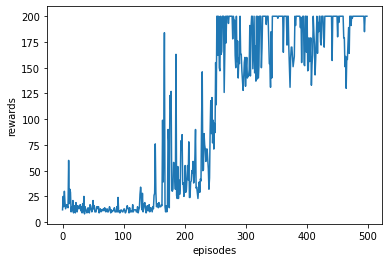

Average Rewards vs episodes


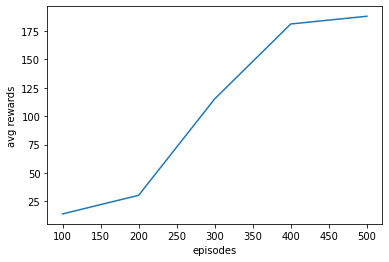

Epsilon vs episodes


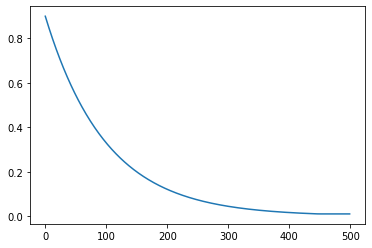

In [59]:
print("Plotting analysis....")
print("Rewards vs episodes")
episodes = list(range(0,env.episodes))
plt1.plot(episodes, env.reward_per_episode)
plt1.xlabel('episodes')
plt1.ylabel('rewards')
plt1.show()

k=0
avg_rewards = []
for i in range(1, int(env.episodes/100)+1):
  avg_rewards.append(np.average(env.reward_per_episode[k:(i*100)-1]))
  k += 100
print("Average Rewards vs episodes")
episodes2 = [x*100 for x in range(1,int(env.episodes/100)+1)]
plt2.plot(episodes2, avg_rewards)
plt2.xlabel('episodes')
plt2.ylabel('avg rewards')
plt2.show()
print("Epsilon vs episodes")
plt3.plot(episodes, env.epsilon_per_episode)
plt3.show()